In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2023-10-10 14:06:44.760640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 14:06:45.245854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [3]:
from eggman.grid import luminosity, log_surface_gravity, calculate_eep

In [4]:
filename = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5"
tracks = pd.read_hdf(filename, "tracks")
tracks.head()

star_mass     Yinit     Zinit      amlt  fov_core  fov_shell
track                                                              
7000     0.92329  0.279311  0.001829  1.608258  0.000000   0.006041
7001     1.72329  0.229311  0.010871  2.308258  0.012396   0.006041
7002     2.12329  0.304311  0.004172  2.658258  0.015861   0.006041
7003     1.32329  0.254311  0.024469  1.958258  0.002481   0.006041
7004     1.12329  0.291811  0.006519  2.133258  0.000000   0.006041

In [5]:
stars = pd.read_hdf(filename, "stars")
stars.head()

star_age    radius         Teff  center_h1    log_LHe  \
track star                                                              
7000  1     2.220454e+07  0.893151  6382.509287   0.718192 -45.291905   
      2     2.300916e+07  0.891027  6377.312552   0.718122 -45.308912   
      3     2.397470e+07  0.890320  6373.785487   0.718037 -45.328570   
      4     3.019433e+07  0.893682  6371.412400   0.717474 -45.392646   
      5     3.259691e+07  0.894573  6371.453759   0.717253 -45.402736   

            log_Lnuc  Dnu_freq_o     eps_o  delta_Pg  
track star                                            
7000  1     0.078416  148.565794  1.129515       0.0  
      2     0.077135  149.148739  1.131800       0.0  
      3     0.075916  149.362908  1.132830       0.0  
      4     0.075178  148.552167  1.130613       0.0  
      5     0.075810  148.331713  1.129892       0.0

In [6]:
grid = tracks.join(stars).reset_index()
grid.head()

track  star  star_mass     Yinit     Zinit      amlt  fov_core  fov_shell  \
0   7000     1    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
1   7000     2    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
2   7000     3    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
3   7000     4    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
4   7000     5    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   

       star_age    radius         Teff  center_h1    log_LHe  log_Lnuc  \
0  2.220454e+07  0.893151  6382.509287   0.718192 -45.291905  0.078416   
1  2.300916e+07  0.891027  6377.312552   0.718122 -45.308912  0.077135   
2  2.397470e+07  0.890320  6373.785487   0.718037 -45.328570  0.075916   
3  3.019433e+07  0.893682  6371.412400   0.717474 -45.392646  0.075178   
4  3.259691e+07  0.894573  6371.453759   0.717253 -45.402736  0.075810   

   Dnu_freq_o     eps_o  delta_Pg  
0  148.565794  1.129515       0.0  
1  149.148739  1.131800       0.0  
2  149.362908  1.132830       0.0  
3  148.552167  1.130613       0.0  
4  148.331713  1.129892       0.0

In [7]:
grid["log_Zinit"] = np.log10(grid.Zinit)
grid["log_age"] = np.log10(grid.star_age)

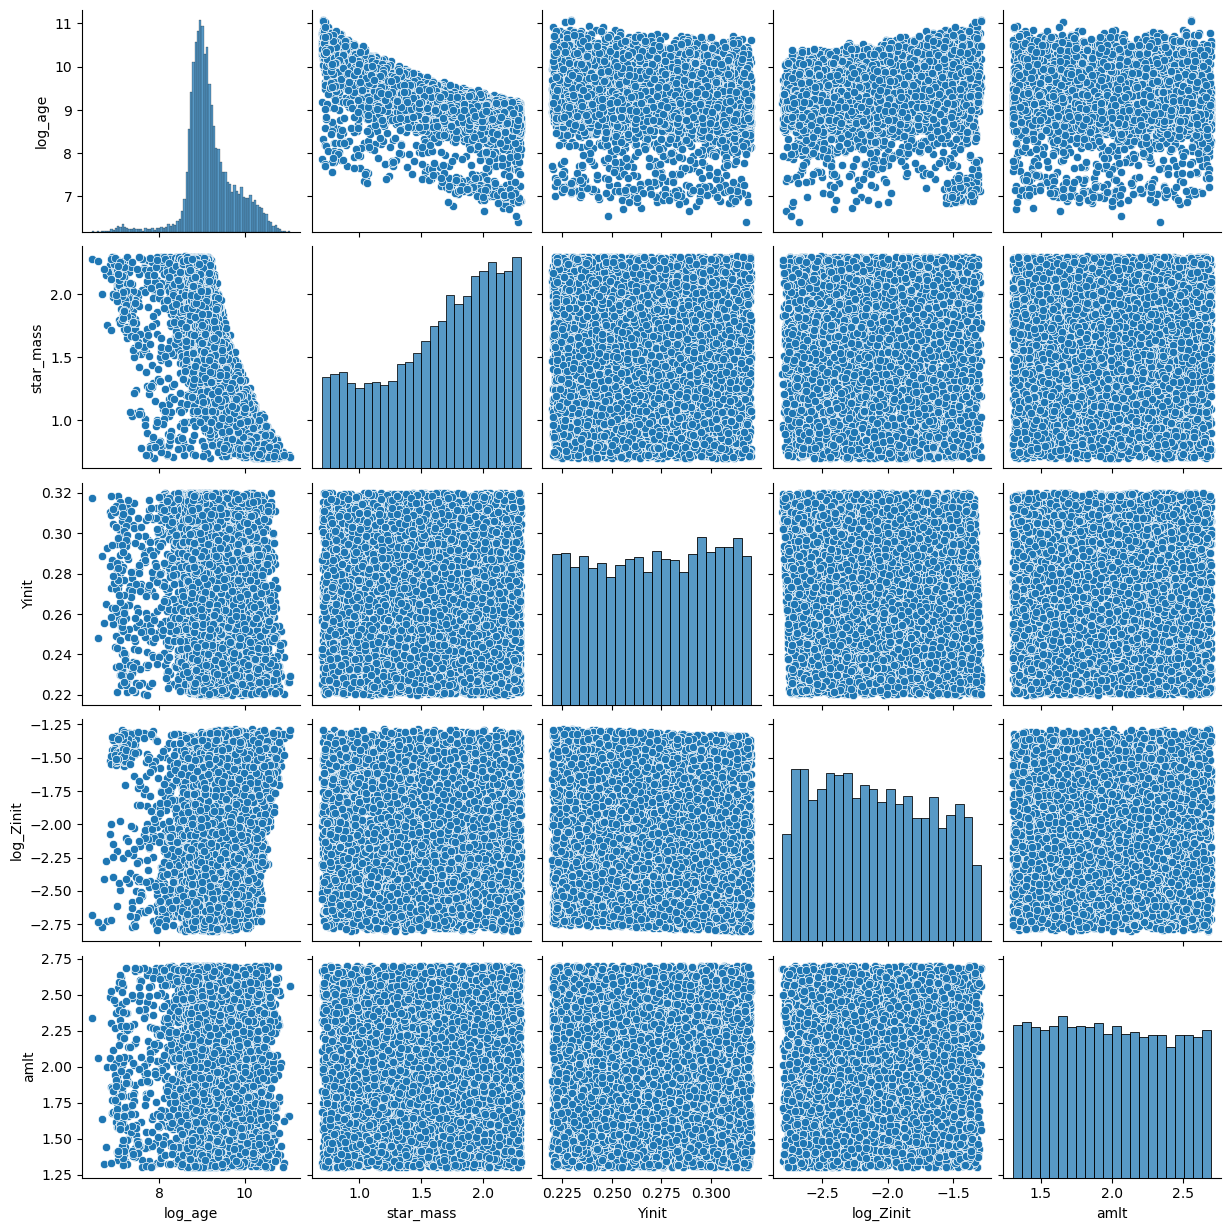

In [8]:
vars = ["log_age", "star_mass", "Yinit", "log_Zinit", "amlt"]
sns.pairplot(grid.sample(10000), vars=vars);

The data needs some cleaning, there are low age patches.

In [9]:
grid["log_Teff"] = np.log10(grid.Teff)
grid["log_R"] = np.log10(grid.radius)
grid["log_Dnu"] = np.log10(grid.Dnu_freq_o)

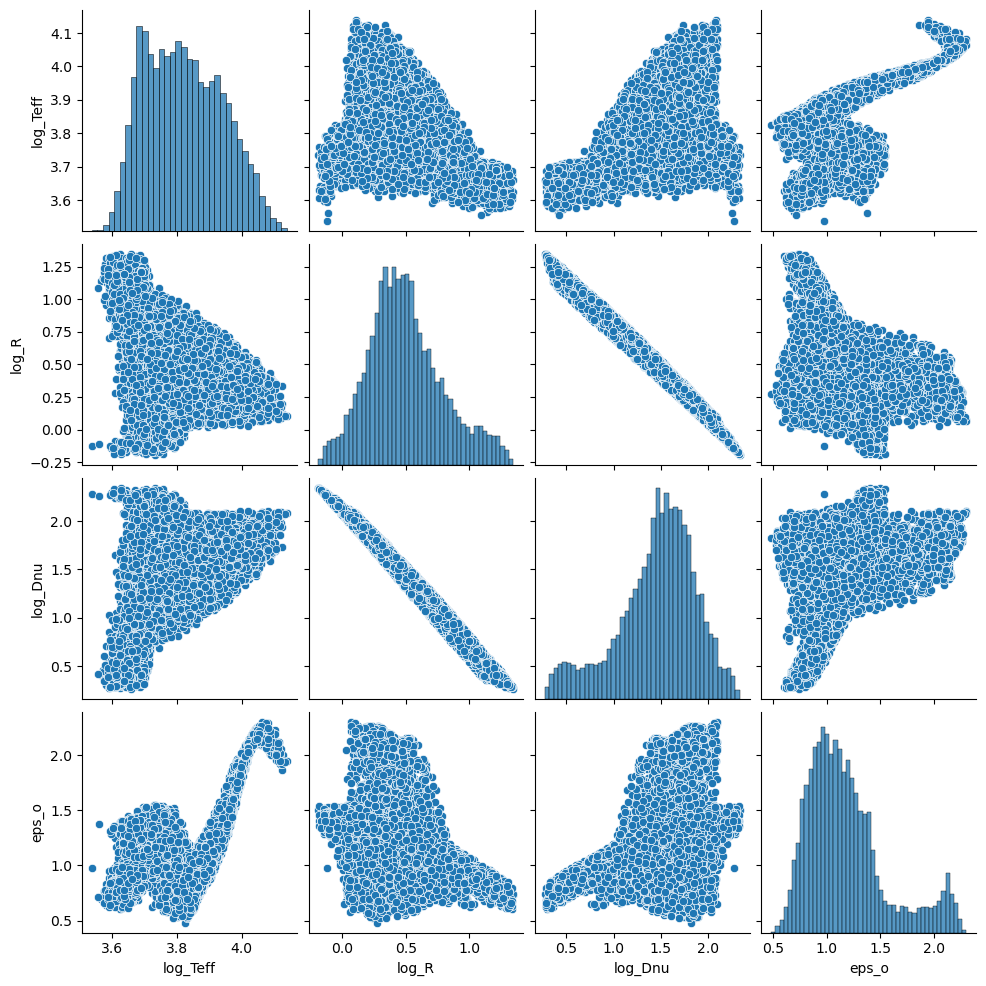

In [10]:
vars = ["log_Teff", "log_R", "log_Dnu", "eps_o"]
sns.pairplot(grid.sample(10000), vars=vars);

In [11]:
data = grid.dropna()
data.head()

track  star  star_mass     Yinit     Zinit      amlt  fov_core  fov_shell  \
0   7000     1    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
1   7000     2    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
2   7000     3    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
3   7000     4    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
4   7000     5    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   

       star_age    radius  ...    log_LHe  log_Lnuc  Dnu_freq_o     eps_o  \
0  2.220454e+07  0.893151  ... -45.291905  0.078416  148.565794  1.129515   
1  2.300916e+07  0.891027  ... -45.308912  0.077135  149.148739  1.131800   
2  2.397470e+07  0.890320  ... -45.328570  0.075916  149.362908  1.132830   
3  3.019433e+07  0.893682  ... -45.392646  0.075178  148.552167  1.130613   
4  3.259691e+07  0.894573  ... -45.402736  0.075810  148.331713  1.129892   

   delta_Pg  log_Zinit   log_age  log_Teff     log_R   log_Dnu  
0       0.0  -2.737812  7.346442  3.804991 -0.049075  2.171919  
1       0.0  -2.737812  7.361901  3.804638 -0.050109  2.173620  
2       0.0  -2.737812  7.379753  3.804397 -0.050454  2.174243  
3       0.0  -2.737812  7.479925  3.804236 -0.048817  2.171879  
4       0.0  -2.737812  7.513176  3.804239 -0.048384  2.171234  

[5 rows x 22 columns]

In [12]:
data["log_g"] = log_surface_gravity(data)
data["log_L"] = np.log10(luminosity(data))

In [13]:
with open("central_hydrogen_problem_tracks.txt") as file:
    bad = list(map(int, file.read().split(",")))

In [14]:
data = data.drop(index=data[data.track.isin(bad)].index)

In [15]:
phase, _ = calculate_eep(data)
data["phase"] = phase

TypeError: calculate_eep() missing 1 required positional argument: 'keys'

In [ ]:
data = data.drop(index=data[data.phase == -1].index)
data

In [ ]:
data.phase.plot(kind="hist")

In [19]:
# dist = pd.Series(np.nan, index=data.index)
eep = pd.Series(np.nan, index=data.index)

eep_keys = ["log_Teff", "log_L", "log_age"]
# eep_keys = ["log_age", "log_Teff", "log_Dnu"]
# weights = np.array([10., 1., 2.])
weights = np.ones(len(eep_keys))
alpha = 0.2
phases = [[0], [1], [2], [3]]
scale = [1, 1, 1, 1]
loc = [sum(scale[:i]) for i in range(len(scale))]
    
for _, group in data.groupby("track"):
    di = ((weights*group[eep_keys].diff()**2).sum(axis=1)**alpha).cumsum()
#     dist.loc[group.index] = di / di.max()

    for i, p in enumerate(phases):
        idx = group[group.phase.isin(p)].index
        lower = idx[0]
        upper = group[group.phase.isin(phases[i+1])].index[0] if i+1 < len(phases) else group.index[-1]
        eep.loc[idx] = loc[i] + scale[i] * (di.loc[idx] - di.loc[lower]) / (di.loc[upper] - di.loc[lower])

In [20]:
data["EEP"] = eep
data["EEP"]

4          0.000000
5          0.017941
6          0.042945
7          0.069534
8          0.097459
             ...   
6587233    3.974897
6587234    3.983205
6587235    3.988839
6587236    3.994431
6587237    4.000000
Name: EEP, Length: 6228873, dtype: float64

In [21]:
rstate = 0
train = data.sample(frac=0.8, random_state=rstate)
test = data.drop(index=train.index)

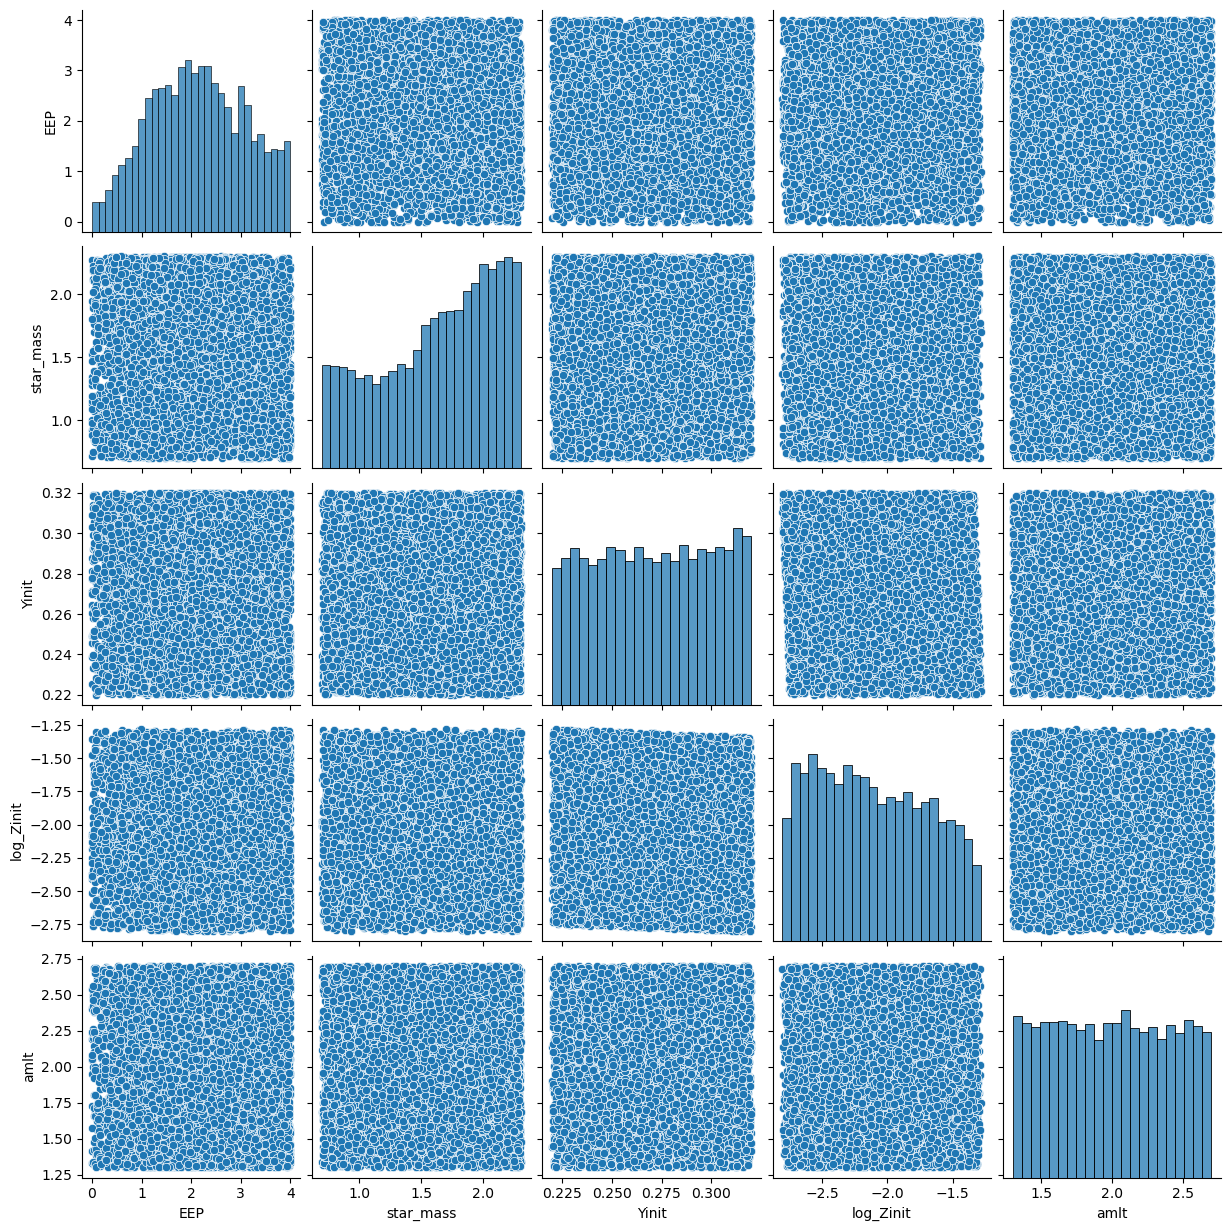

In [22]:
features = ["EEP", "star_mass", "Yinit", "log_Zinit", "amlt"]
sns.pairplot(train.sample(10000), vars=features);

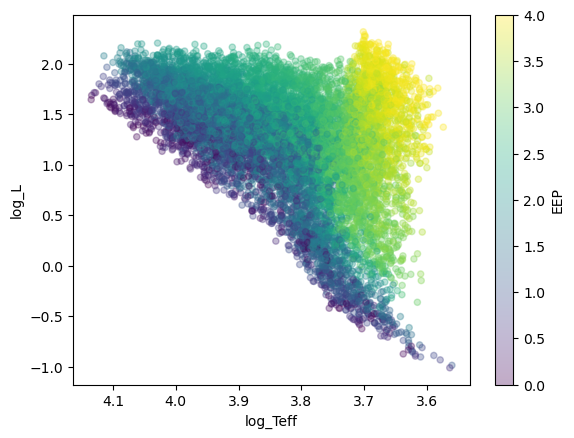

In [23]:
ax = data.sample(10000).plot(x="log_Teff", y="log_L", c="EEP", cmap="viridis", kind="scatter", alpha=0.33)
ax.invert_xaxis()

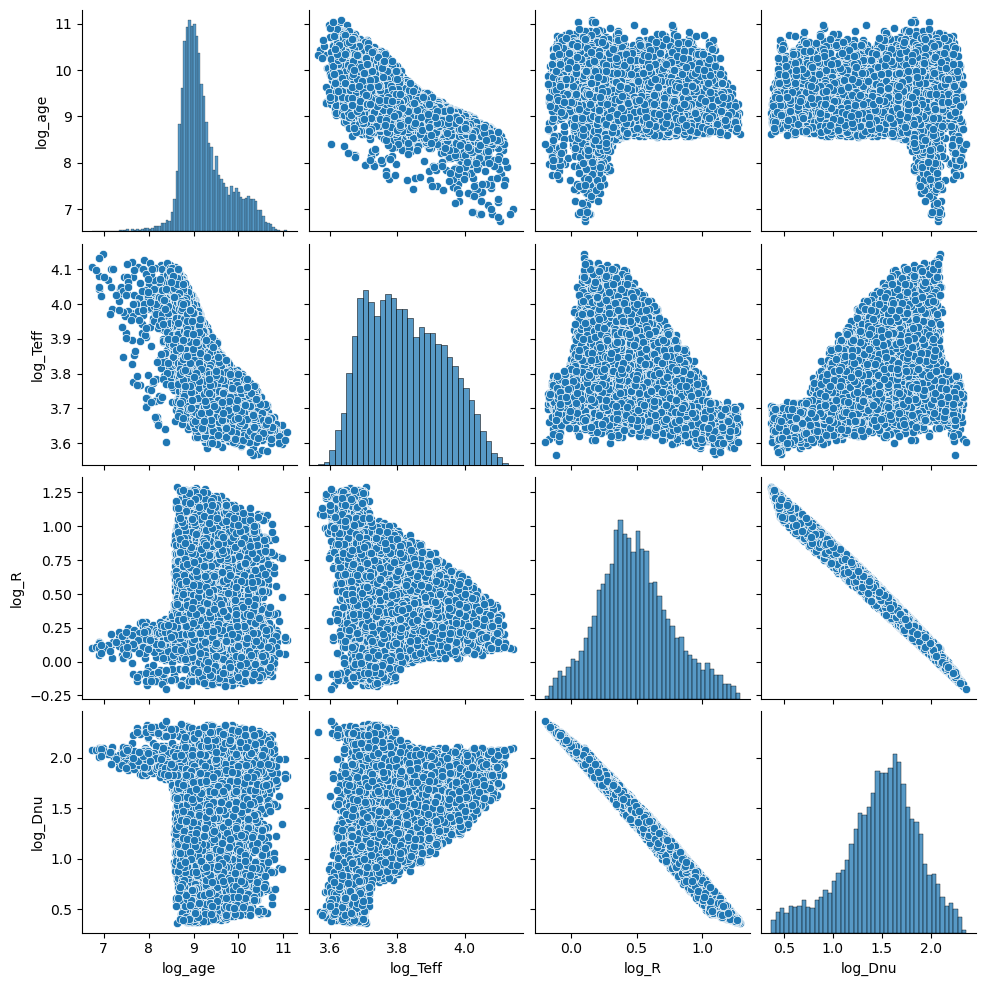

In [24]:
labels = ["log_age", "log_Teff", "log_R", "log_Dnu"]
sns.pairplot(train.sample(10000), vars=labels);

In [26]:
train_features = train[features].astype(np.float32).copy()
test_features = test[features].astype(np.float32).copy()

train_labels = train[labels].astype(np.float32).copy()
test_labels = test[labels].astype(np.float32).copy()

In [25]:
from scipy.stats import gaussian_kde

In [44]:
kde = gaussian_kde(train_labels.sample(1000).T)

In [46]:
w = kde.evaluate(train_labels.T)

In [62]:
1/w

array([0.02359788, 0.10716659, 0.01012868, ..., 0.37532619, 0.01854908,
       0.04307651])

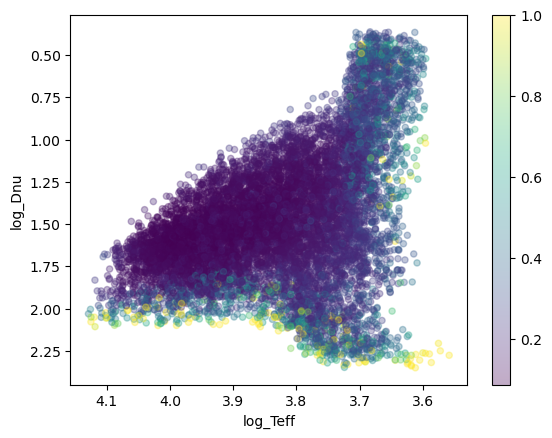

In [65]:
num_first = 10000
ax = train_labels.iloc[:num_first].plot(x="log_Teff", y="log_Dnu", c=1/w[:num_first]**0.5, cmap="viridis", 
                                        kind="scatter", alpha=0.33, vmax=1)
ax.invert_xaxis()
ax.invert_yaxis()

In [66]:
normalizer = layers.Normalization(axis=-1)

In [67]:
normalizer.adapt(np.array(train_features), batch_size=len(train_features))
print(normalizer.mean.numpy())

2023-06-22 11:28:22.315184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18163 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-06-22 11:28:22.315645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18237 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:61:00.0, compute capability: 8.6


[[ 2.1288695   1.6388708   0.27121973 -2.108368    1.9911563 ]]


In [68]:
label_offset = train_labels.mean().to_numpy()
label_scale = train_labels.std().to_numpy()

rescaler = layers.Rescaling(label_scale, offset=label_offset)

In [69]:
activation = "elu"
arch = (6, 128)

model = tf.keras.Sequential(
    [normalizer] +
    [layers.Dense(arch[1], activation) for _ in range(arch[0])] +
    [layers.Dense(len(labels)), rescaler]
)

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               768       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                        

In [106]:
learning_rate = 1e-4
beta_1 = 0.9
beta_2 = 0.999
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)

loss = 'mean_squared_error'

model.compile(
    optimizer,
    loss=loss,
    weighted_metrics=[],
)

In [107]:
epochs = 10
batch_size = 4096
# sample_weight = pd.Series(1/w**0.5, index=train_labels.index, dtype=np.float32).to_frame("weight")
# sample_weight

In [119]:
%%time
history = model.fit(
    train_features,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
#     sample_weight=sample_weight,
    # Suppress logging.
#     verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

Epoch 1/10
974/974 [==============================] - 4s 4ms/step - loss: 9.3759e-05 - val_loss: 9.2723e-05
Epoch 2/10
974/974 [==============================] - 4s 4ms/step - loss: 9.1257e-05 - val_loss: 9.2412e-05
Epoch 3/10
974/974 [==============================] - 4s 4ms/step - loss: 8.9812e-05 - val_loss: 8.6602e-05
Epoch 4/10
974/974 [==============================] - 4s 4ms/step - loss: 8.7571e-05 - val_loss: 8.4710e-05
Epoch 5/10
974/974 [==============================] - 4s 4ms/step - loss: 8.6003e-05 - val_loss: 8.3808e-05
Epoch 6/10
974/974 [==============================] - 4s 4ms/step - loss: 8.4153e-05 - val_loss: 8.5340e-05
Epoch 7/10
974/974 [==============================] - 3s 3ms/step - loss: 8.2512e-05 - val_loss: 8.2724e-05
Epoch 8/10
974/974 [==============================] - 3s 3ms/step - loss: 8.1403e-05 - val_loss: 8.4011e-05
Epoch 9/10
974/974 [==============================] - 4s 4ms/step - loss: 8.0051e-05 - val_loss: 7.8786e-05
Epoch 10/10
974/974 [=======

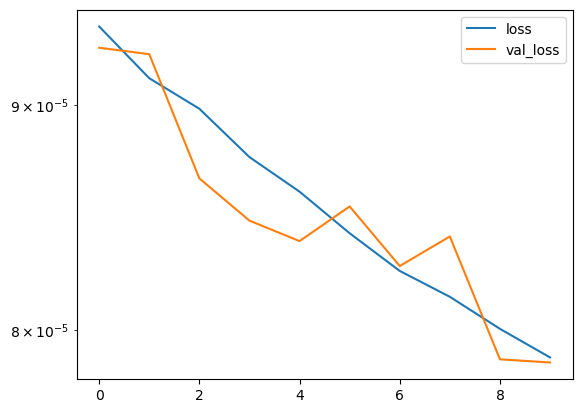

In [120]:
fig, ax = plt.subplots()

ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend()
ax.set_yscale("log")

In [121]:
model.predict(train_features.iloc[:2])

1/1 [==============================] - 0s 12ms/step


array([[ 9.6286449e+00,  3.7555392e+00,  3.9683715e-01,  1.5841033e+00],
       [ 9.5356989e+00,  3.7966187e+00, -7.2109997e-03,  2.1207702e+00]],
      dtype=float32)

In [122]:
train_labels.iloc[:2]

log_age  log_Teff     log_R   log_Dnu
4239372  9.623608  3.756668  0.397768  1.577576
4364990  9.552631  3.795451 -0.006648  2.109143

In [123]:
train_pred = model(train_features)

In [124]:
log_error = train_labels - train_pred.numpy()

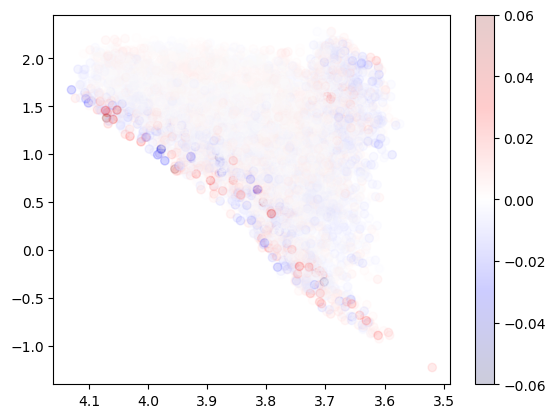

In [125]:
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample.log_Teff, data.loc[sample.index, "log_L"], c=log_error.loc[sample.index].mean(axis=1), 
               cmap="seismic", alpha=0.2, vmin=-0.06, vmax=0.06)
fig.colorbar(s)

ax.invert_xaxis()

In [126]:
mse = ((train_labels - train_pred.numpy())**2).mean(axis=1)

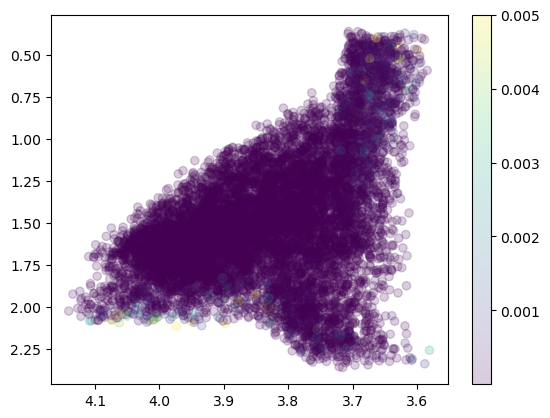

In [127]:
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample.log_Teff, sample.log_Dnu, c=mse.loc[sample.index], alpha=0.2, vmax=0.005)
fig.colorbar(s)

ax.invert_xaxis()
ax.invert_yaxis()

In [128]:
error = 10**train_labels - 10**train_pred.numpy()
error

log_age   log_Teff     log_R   log_Dnu
4239372  -48161280.0  14.239746  0.005909 -0.567139
4364990  138533888.0 -17.189453  0.000935 -3.428665
3633770   -6264960.0  68.454102 -0.051798  1.434189
5992731    1277952.0  22.030762 -0.041327  0.152989
3832114    5614784.0  23.369141 -0.006943  0.106297
...              ...        ...       ...       ...
2159277  -13308672.0  24.665527 -0.146179  0.429381
241230     -889216.0  47.995117 -0.114818  0.482393
5052492  -16232960.0 -18.424316  0.059816 -0.016096
2324695    -335584.0  16.062500 -0.002937  0.210533
314204   257546240.0  49.732910 -0.003020 -0.252457

[4983098 rows x 4 columns]

In [129]:
error.mean()

log_age    -3.469158e+06
log_Teff    8.216472e+00
log_R       2.544966e-03
log_Dnu     1.795969e-02
dtype: float32

In [130]:
error.std()

log_age     1.655161e+08
log_Teff    4.415385e+01
log_R       1.611751e-01
log_Dnu     7.635553e-01
dtype: float32

In [131]:
log_error

log_age  log_Teff     log_R   log_Dnu
4239372 -0.004948  0.001084  0.001028 -0.006466
4364990  0.017190 -0.001194  0.000413 -0.011430
3633770 -0.001965  0.003642 -0.009672  0.013925
5992731  0.000400  0.001981 -0.003163  0.004499
3832114  0.002559  0.001216 -0.001040  0.001414
...           ...       ...       ...       ...
2159277 -0.002480  0.002002 -0.011258  0.016448
241230  -0.000463  0.003007 -0.010499  0.011336
5052492 -0.002382 -0.001636  0.002085 -0.002103
2324695 -0.000289  0.000618 -0.000751  0.001234
314204   0.004410  0.004112 -0.001340 -0.000920

[4983098 rows x 4 columns]

In [132]:
num_points = 201
example_features = np.stack([
    np.linspace(0, 6, num_points),
    np.ones(num_points),
    np.ones(num_points) * 0.26,
    np.ones(num_points) * -2,
    np.ones(num_points) * 2,
], axis=-1)

In [133]:
example_labels = model(example_features).numpy()

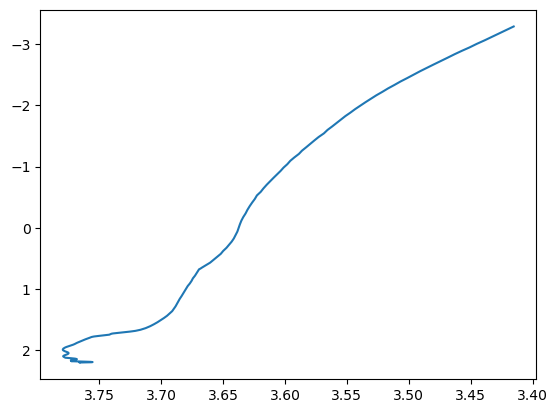

In [134]:
fig, ax = plt.subplots()

ax.plot(example_labels[:, 1], example_labels[:, 3])
ax.invert_xaxis()
ax.invert_yaxis()